In [1]:
import sys  
sys.path.insert(0, './../')
import numpy as np
import bbdc2021 as bbdc
import pandas as pd
from importlib import reload
reload(bbdc)
import tensorflow as tf
from keras import layers
import keras
from keras import backend as K
from itertools import groupby
import matplotlib.pyplot as plt
from matplotlib import colors 
import models.cnn.u_net_1d as unet
reload(unet)
import evaluation.evaluate as evaluate

In [2]:
np.random.seed(1)
tf.random.set_seed(1)
pathToDataset = "dataset_fft_mel_l04_o02495_f32/"

In [3]:
X_train, Y_train, timepoints, trainFileList = bbdc.load_data("train.csv", pathToDataset+"dev/")
X_validation, Y_validation, timepoints, validationFileList = bbdc.load_data("validation.csv", pathToDataset+"dev/")  
X_test, Y_test, timepoints, testFileList = bbdc.load_data("test.csv", pathToDataset+"dev/")

inputShape = X_train[0].shape

24009it [01:58, 202.12it/s]
3047it [00:15, 202.95it/s]
2988it [00:11, 251.46it/s]


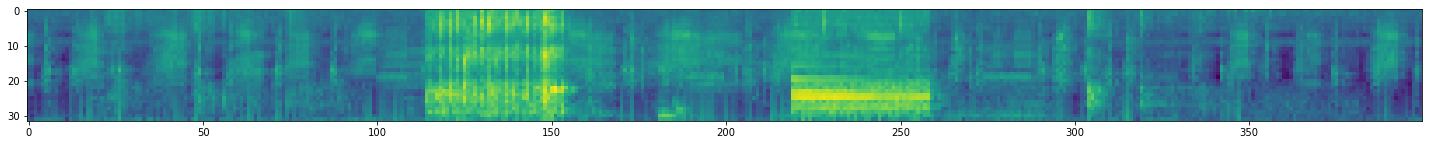

In [4]:
plt.figure(figsize=(25,5))
plt.imshow(np.rot90(X_train[0]))

In [17]:
X_challenge, _, timepoints, challengeFileList = bbdc.load_data("challenge_filelist_dummy.csv", pathToDataset+"eval/")
inputShape = X_challenge[0].shape

3000it [00:42, 71.27it/s]


In [ ]:
print(tf.__version__)
print(X_train.shape)

In [5]:
channels = [32, 64, 90]
model = unet.u_net(inputShape, channels, lessParameter = True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 32)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 400, 32)      1056        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 400, 32)      128         conv1d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 400, 32)      0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
#Mit crossentropy
#checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
checkpoint = keras.callbacks.ModelCheckpoint('model.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['mae', 'accuracy'])
history = model.fit(X_train,Y_train, batch_size=15, epochs=100, validation_data=(X_validation, Y_validation), shuffle=True, callbacks=[checkpoint])

Epoch 1/100
534/534 [==============================] - 37s 63ms/step - loss: 1.4496 - mae: 0.0876 - accuracy: 0.6076 - val_loss: 0.8585 - val_mae: 0.0571 - val_accuracy: 0.7465

Epoch 00001: val_loss improved from inf to 0.85853, saving model to model.h5
Epoch 2/100
534/534 [==============================] - 32s 61ms/step - loss: 0.7931 - mae: 0.0506 - accuracy: 0.7645 - val_loss: 0.7190 - val_mae: 0.0461 - val_accuracy: 0.7877

Epoch 00002: val_loss improved from 0.85853 to 0.71896, saving model to model.h5
Epoch 3/100
534/534 [==============================] - 32s 60ms/step - loss: 0.6638 - mae: 0.0430 - accuracy: 0.8034 - val_loss: 0.6155 - val_mae: 0.0401 - val_accuracy: 0.8163

Epoch 00003: val_loss improved from 0.71896 to 0.61546, saving model to model.h5
Epoch 4/100
534/534 [==============================] - 33s 62ms/step - loss: 0.5960 - mae: 0.0390 - accuracy: 0.8240 - val_loss: 0.5906 - val_mae: 0.0382 - val_accuracy: 0.8249

Epoch 00004: val_loss improved from 0.61546 to 0.

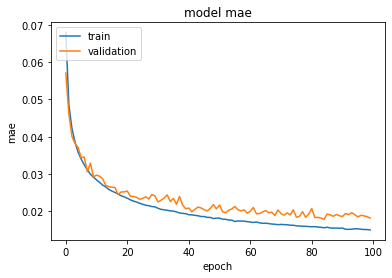

In [7]:
# summarize history for mae
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

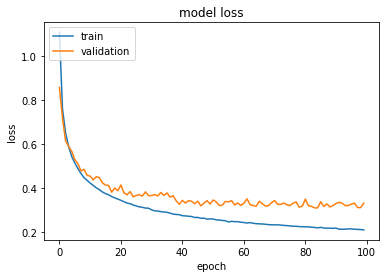

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

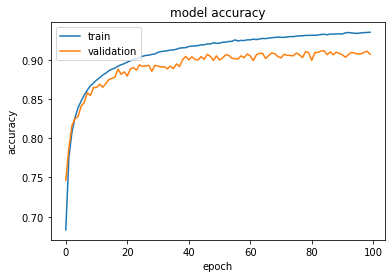

In [9]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [10]:
#model = keras.models.load_model("Modelle_Jannes/")
prediction = model.predict(X_test)

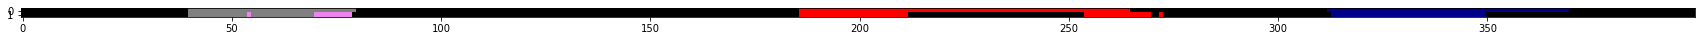

In [11]:
bbdc.plotPredictionAndGT(Y_test, prediction, 4)

In [12]:
scores = model.evaluate(X_test, Y_test)


32/32 [==============================] - 1s 28ms/step - loss: 0.3185 - mae: 0.0180 - accuracy: 0.9083


In [13]:
df = bbdc.getPredictionAsSequenceDF(prediction, timepoints, testFileList)
df.to_csv("../predictions/jannes/LP1d_Prediction_mel_test.csv", index=False)
df.head()
evaluate.evaluate("../predictions/jannes/LP1d_Prediction_mel_test.csv", "./../data/test.csv")

(0.20184843640174135, 'Valid file')

In [14]:
postProcessedPrediction = np.array([bbdc.postProcess(pred, timepoints) for pred in prediction])
df = bbdc.getPredictionAsSequenceDF(postProcessedPrediction, timepoints, testFileList)
df.to_csv("../predictions/jannes/LP1d_Prediction_mel_pp_test.csv", index=False)
print(evaluate.evaluate("../predictions/jannes/LP1d_Prediction_mel_pp_test.csv", "./../data/test.csv"))

(0.831134109757114, 'Valid file')


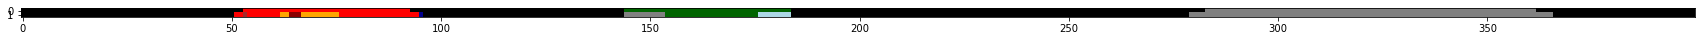

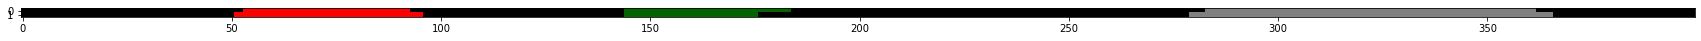

In [15]:
index = 14
bbdc.plotPredictionAndGT(Y_test, prediction, index) #TODO Problem mit falscher Farbdarstellung lösen
bbdc.plotPredictionAndGT(Y_test, postProcessedPrediction, index)

# Evaluation mit Validationset

In [25]:
prediction = model.predict(X_validation)
discretePrediction = (prediction == prediction.max(axis=1)[:,None]).astype(int)
model.evaluate(X_validation, Y_validation)
df = bbdc.getPredictionAsSequenceDF(prediction, timepoints, validationFileList)
df.to_csv("../predictions/jannes/LP1d_Prediction_val.csv", index=False)
print(evaluate.evaluate("../predictions/jannes/LP1d_Prediction_val.csv", "./../data/validation.csv"))

postProcessedPrediction = np.array([bbdc.postProcess(pred, timepoints) for pred in prediction])
df = bbdc.getPredictionAsSequenceDF(postProcessedPrediction, timepoints, validationFileList)
df.to_csv("../predictions/jannes/LP1d_Prediction_pp_val.csv", index=False)
print(evaluate.evaluate("../predictions/jannes/LP1d_Prediction_pp_val.csv", "./../data/validation.csv"))

32/32 [==============================] - 0s 10ms/step - loss: 0.3118 - mae: 0.0179 - accuracy: 0.9119
(0.10671975887168393, 'Valid file')
(0.8564091127358349, 'Valid file')


# Prediction der Challenge

In [18]:
#model = keras.models.load_model("Modelle_Jannes/model9561.h5")
prediction = model.predict(X_challenge)
postProcessedPredictionChallenge = np.array([bbdc.postProcess(pred, timepoints) for pred in prediction])
df = bbdc.getPredictionAsSequenceDF(postProcessedPredictionChallenge, timepoints, challengeFileList, calculateProbs=True)
df.to_csv("../predictions/jannes/LP1d_PredictionChallenge_mel_probs3.csv", index=False)

/home/jannes/Programme/miniconda3/envs/gpuclone/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jannes/Programme/miniconda3/envs/gpuclone/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
